## Step 1: Import required libraries

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf

## Step 2: Import the dataset

In [2]:
# Reading the csv file as a dataframe using pandas
# Viewing the first 5 rows of the dataframe

df = pd.read_csv('data.csv',encoding='latin-1')
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1.0
1,NaN,Did they post their votes for Hillary already?,1.0
2,UNBELIEVABLE! OBAMAâS ATTORNEY GENERAL SAYS ...,"Now, most of the demonstrators gathered last ...",1.0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0.0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1.0


### Step 3: Data Cleaning

* Convert label column from numerical to categorical
* Handle the null values

In [3]:
# Converting the label column into categorical variable 
# as it defines whether the news is real(1) or fake(0)

df['label'] = df['label'].astype('category')

In [4]:
# Getting basic information about the data
print("Basic information about the dataset : ")
print(df.info())
print("Null value counts for each column : ")
print(df.isnull().sum())

Basic information about the dataset : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72140 entries, 0 to 72139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   71444 non-null  object  
 1   text    71963 non-null  object  
 2   label   72002 non-null  category
dtypes: category(1), object(2)
memory usage: 1.2+ MB
None
Null value counts for each column : 
title    696
text     177
label    138
dtype: int64


Since the null values amount to less than 1% of the total number of rows, we can drop them without impacting the data.

In [5]:
# Drop all the null values from the dataframe
df.dropna(inplace=True)

# Check if there are any null values remaining
print(df.isnull().sum())

# Print the dataframe info
print(df.info())

title    0
text     0
label    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 71405 entries, 0 to 72139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   71405 non-null  object  
 1   text    71405 non-null  object  
 2   label   71405 non-null  category
dtypes: category(1), object(2)
memory usage: 1.7+ MB
None


## Step 4: Exploratory Data Analysis

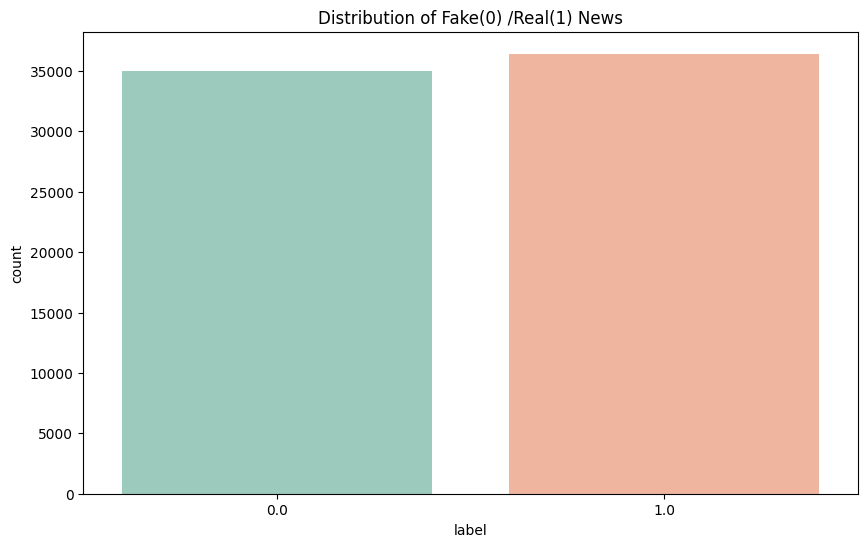

In [6]:
# Plot the distribution of the data based on the labels
plt.figure(figsize = (10,6))
sns.countplot(x=df['label'], hue=df['label'], palette='Set2', alpha=0.7, legend=False)
plt.title('Distribution of Fake(0) /Real(1) News')
plt.show()

We see that the data is almost evenly distributed between lable 1 and 0

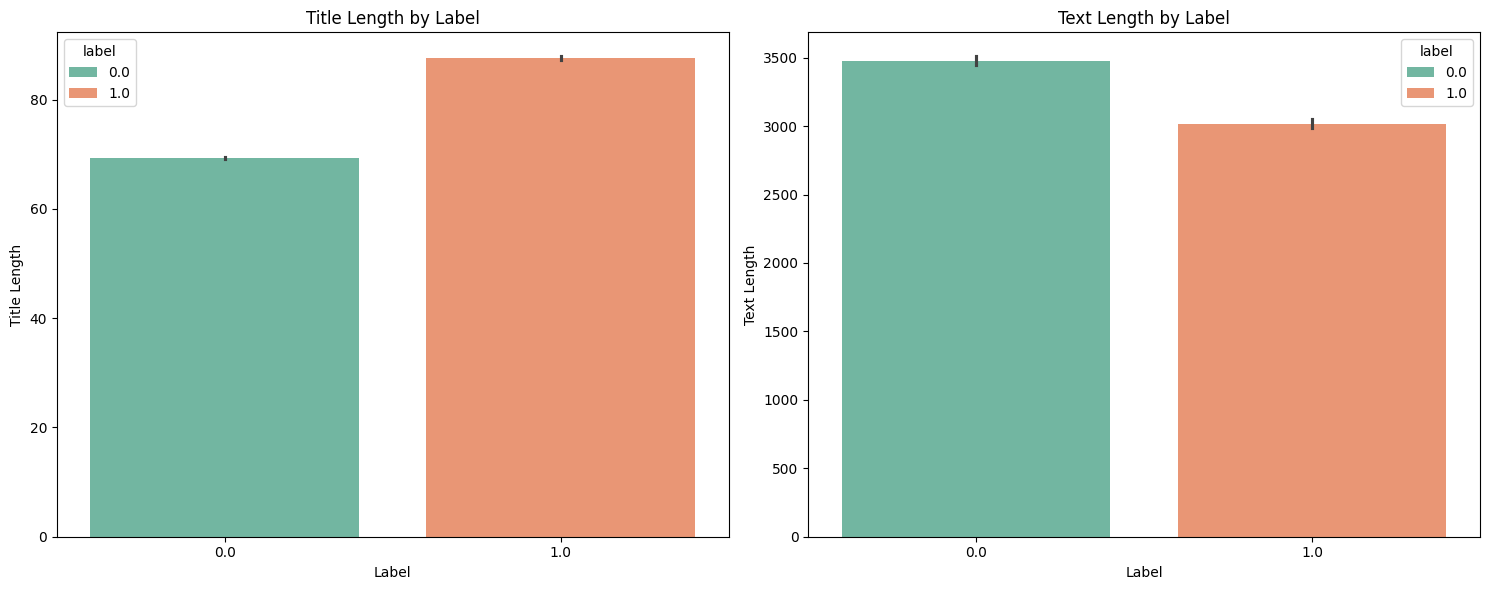

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df['title_length'] = df['title'].apply(len)
df['text_length'] = df['text'].apply(len)

# Plotting a bar chart for title length vs label
sns.barplot(x="label", y="title_length", data=df, palette="Set2",hue="label", ax=axes[0])
axes[0].set_title("Title Length by Label")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Title Length")

# Plotting a bar chart for text length vs label
sns.barplot(x="label", y="text_length", data=df, palette="Set2",hue="label", ax=axes[1])
axes[1].set_title("Text Length by Label")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Text Length")

plt.tight_layout()
plt.show()


Here, we observe that real news articles tend to have significantly longer titles compared to the fake news articles. In contrast, the real news articles seem to have shorter text compared to the fake articles.

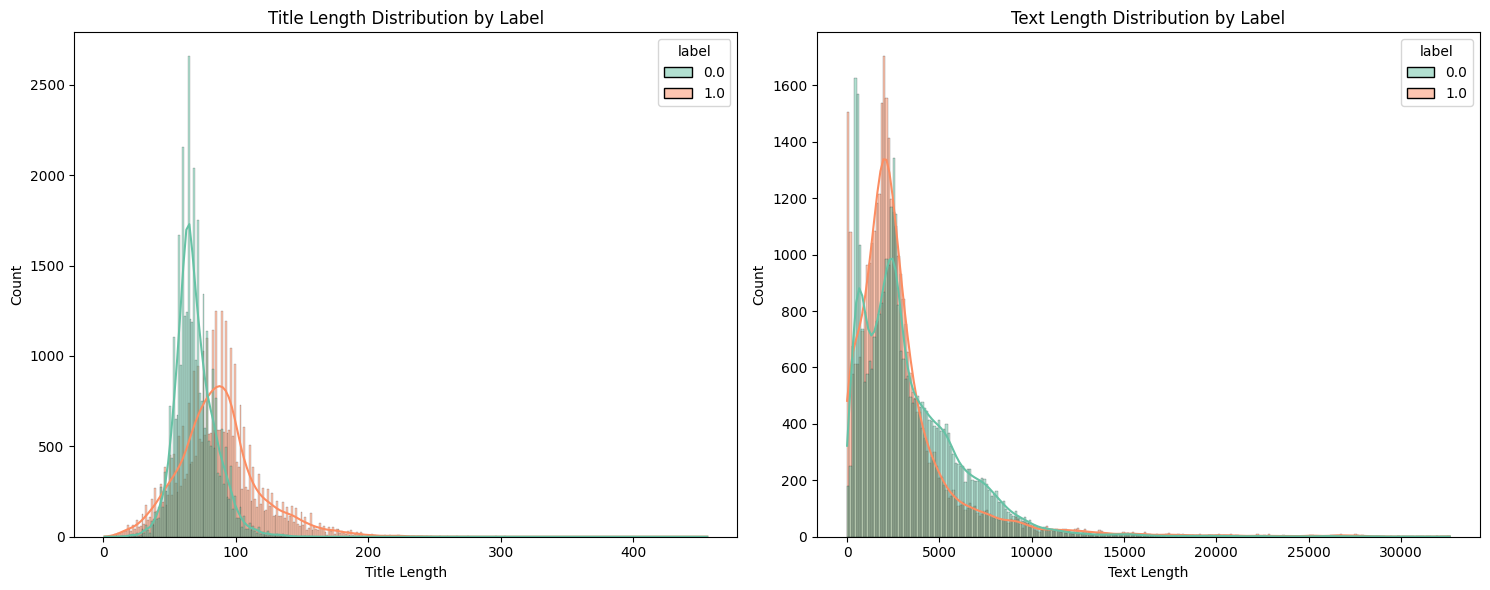

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the title length distribution
sns.histplot(df, x="title_length", hue="label", palette="Set2", kde=True, ax=axes[0])
axes[0].set_title("Title Length Distribution by Label")
axes[0].set_xlabel("Title Length")
axes[0].set_ylabel("Count")

# Plot the text length distribution
sns.histplot(df, x="text_length", hue="label", palette="Set2", kde=True, ax=axes[1])
axes[1].set_title("Text Length Distribution by Label")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


Both the histograms seems to be right skewed. It means that the mode < median < mean of the data.

## Step 5: Data Preprocessing
* Remove any special characters (which are not alphabets or numbers) from the text and title
* Convert title and text into lower case
* Split the sentences into individual words
* Remove the common stopwords

In [9]:
def preprocess_text(text):
    # Step 1: Text Cleaning - Remove special characters
    cleaned_text = re.sub(r'<.*?>', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)

    # Step 2: Split the text into words
    words = word_tokenize(cleaned_text)

    # Step 3: Convert words to lowercase
    lc_words = [word.lower() for word in words]

    # Step 4: Remove common stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [token for token in lc_words if token not in stop_words]
    
    # Step 5: Reduce words to their base forms
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(token) for token in filtered_words]
    preprocessed_text = ' '.join(lemmatized_words)

    return preprocessed_text

# Apply text preprocessing to 'title' and 'text' columns
df['new_title'] = df['title'].apply(preprocess_text)
df['new_text'] = df['text'].apply(preprocess_text)

print(df[['new_title', 'new_text']].head())

                                           new_title  \
0  law enforcement high alert following threat co...   
2  unbelievable obamas attorney general say charl...   
3  bobby jindal raised hindu us story christian c...   
4  satan 2 russia unvelis image terrifying new su...   
5  time christian group sue amazon splc designati...   

                                            new_text  
0  comment expected barack obama member fyf911 fu...  
2  demonstrator gathered last night exercising co...  
3  dozen politically active pastor came private d...  
4  rs28 sarmat missile dubbed satan 2 replace ss1...  
5  say one time someone sued southern poverty law...  


In [10]:
# Define parameters for tokenizer and padding
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['new_title'])
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df['new_title'])
padded_seq = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Padded Sequences:")
print(padded_seq)

Padded Sequences:
[[ 76   1 351 ...   0   0   0]
 [  1  61 340 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 ...
 [280 455 472 ...   0   0   0]
 [  2   1  95 ...   0   0   0]
 [  1   1   1 ...   0   0   0]]


## Step 6: Split the data and train different models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded_seq, df['label'].values, test_size=0.2, random_state=42)
print(f'X_train Shape = {X_train.shape}, X_train type = {type(X_train)}')
print(f'X_test Shape = {X_test.shape}, X_test type = {type(X_test)}')
print(f'y_train Shape = {y_train.shape}, y_train type = {type(y_train)}')
print(f'y_test Shape = {y_test.shape}, y_test type = {type(y_test)}')

X_train Shape = (57124, 50), X_train type = <class 'numpy.ndarray'>
X_test Shape = (14281, 50), X_test type = <class 'numpy.ndarray'>
y_train Shape = (57124,), y_train type = <class 'pandas.core.arrays.categorical.Categorical'>
y_test Shape = (14281,), y_test type = <class 'pandas.core.arrays.categorical.Categorical'>


### Logistic Regression

Test Accuracy: 0.62
              precision    recall  f1-score   support

         0.0       0.58      0.76      0.66      6959
         1.0       0.68      0.48      0.57      7322

    accuracy                           0.62     14281
   macro avg       0.63      0.62      0.61     14281
weighted avg       0.63      0.62      0.61     14281



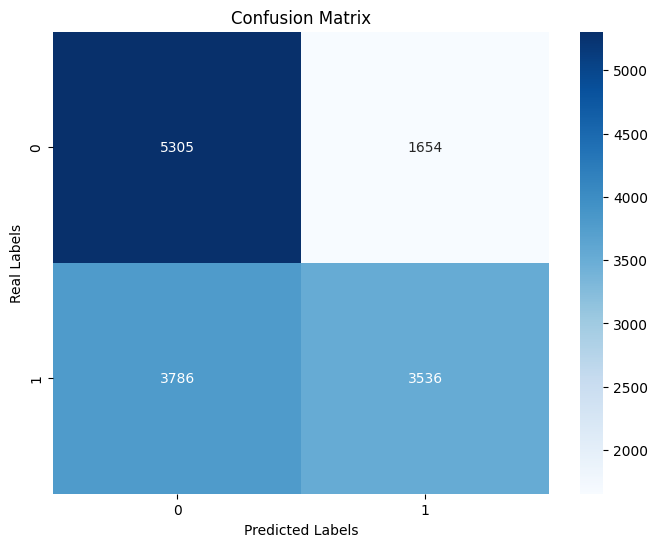

In [12]:
model = LogisticRegression(max_iter=10000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy metrics of the model
lr_accuracy = round(accuracy_score(y_test, y_pred),2)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Test Accuracy:", lr_accuracy)
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree Classifier

Test Accuracy: 0.78
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      6959
         1.0       0.77      0.81      0.79      7322

    accuracy                           0.78     14281
   macro avg       0.78      0.78      0.78     14281
weighted avg       0.78      0.78      0.78     14281



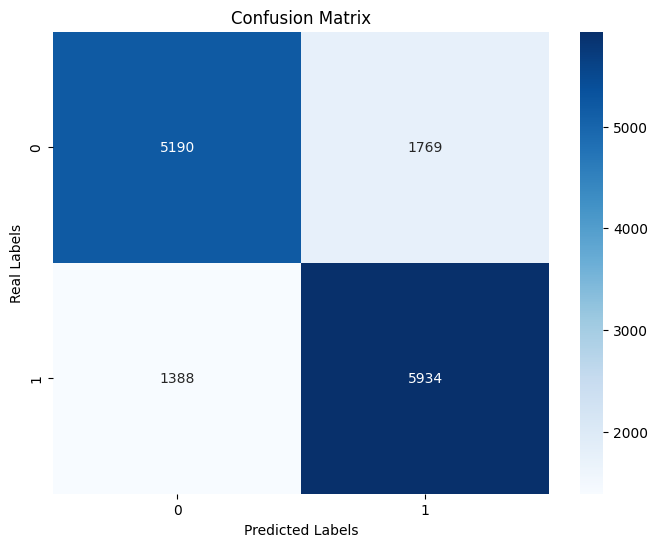

In [13]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy metrics of the model
dt_accuracy = round(accuracy_score(y_test, y_pred),2)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Test Accuracy:", dt_accuracy)
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()


### Random Forest Classifier

Test Accuracy: 0.82
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      6959
         1.0       0.83      0.81      0.82      7322

    accuracy                           0.82     14281
   macro avg       0.82      0.82      0.82     14281
weighted avg       0.82      0.82      0.82     14281



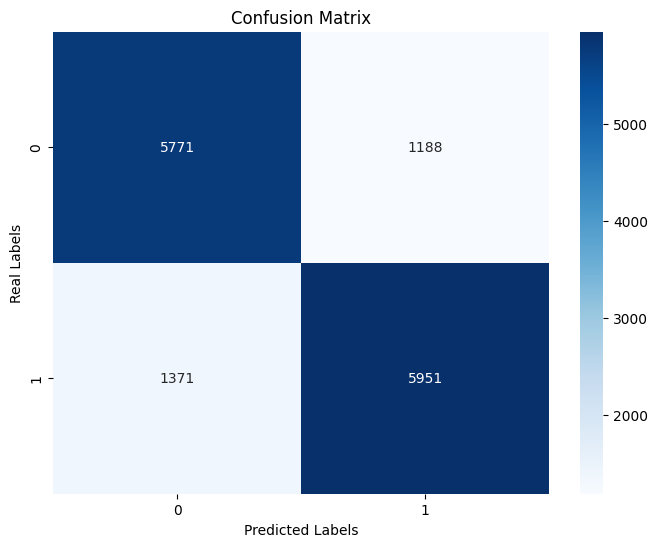

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy metrics of the model
rf_accuracy = round(accuracy_score(y_test, y_pred),2)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Test Accuracy:", rf_accuracy)
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

### KNN Classifier

Test Accuracy: 0.63
              precision    recall  f1-score   support

         0.0       0.60      0.76      0.67      6959
         1.0       0.69      0.51      0.59      7322

    accuracy                           0.63     14281
   macro avg       0.64      0.63      0.63     14281
weighted avg       0.64      0.63      0.63     14281



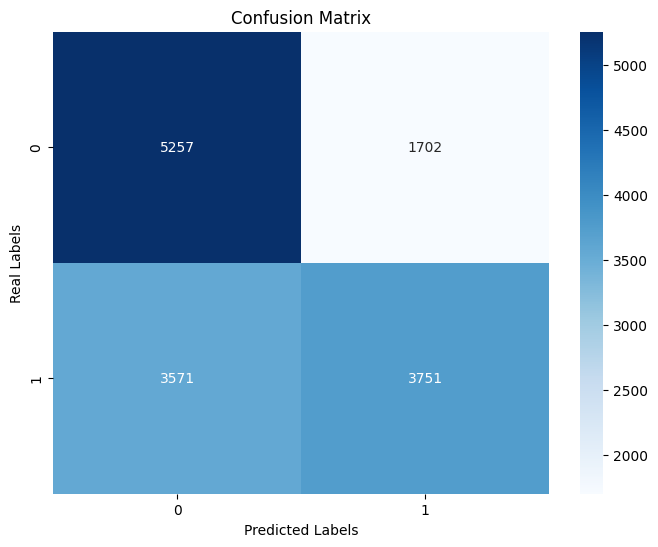

In [15]:
knn_classifier = KNeighborsClassifier(n_neighbors=4)

# Fit the classifier to the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier.predict(X_test)

# Calculate the accuracy metrics of the model
knn_accuracy = round(accuracy_score(y_test, y_pred),2)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Test Accuracy:", knn_accuracy)
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

### Naive Bayes Classifier

Test Accuracy: 0.6
              precision    recall  f1-score   support

         0.0       0.56      0.89      0.69      6959
         1.0       0.76      0.33      0.46      7322

    accuracy                           0.60     14281
   macro avg       0.66      0.61      0.58     14281
weighted avg       0.66      0.60      0.57     14281



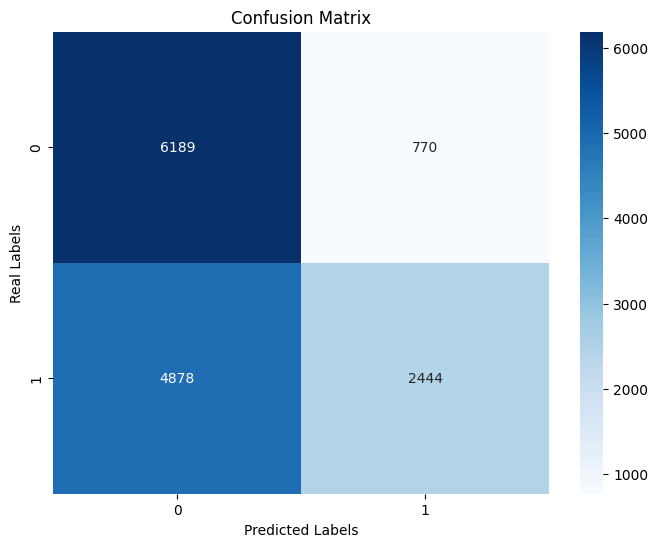

In [16]:
nb_classifier = MultinomialNB()

# Train the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test)

# Calculate the accuracy metrics of the model
nb_accuracy = round(accuracy_score(y_test, y_pred),2)
confusion = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Test Accuracy:", nb_accuracy)
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

### Classification using Neural Network

In [17]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 8109 (31.68 KB)
Trainable params: 8109 (31.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Convert the target variable to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [19]:
# Train the model
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/10


1786/1786 [==============================] - 8s 4ms/step - loss: 0.4734 - accuracy: 0.7742 - val_loss: 0.3487 - val_accuracy: 0.8366
Epoch 2/10
1786/1786 [==============================] - 6s 3ms/step - loss: 0.3459 - accuracy: 0.8342 - val_loss: 0.3414 - val_accuracy: 0.8336
Epoch 3/10
1786/1786 [==============================] - 6s 3ms/step - loss: 0.3381 - accuracy: 0.8393 - val_loss: 0.3312 - val_accuracy: 0.8434
Epoch 4/10
1786/1786 [==============================] - 6s 3ms/step - loss: 0.3358 - accuracy: 0.8393 - val_loss: 0.3299 - val_accuracy: 0.8460
Epoch 5/10
1786/1786 [==============================] - 6s 3ms/step - loss: 0.3352 - accuracy: 0.8409 - val_loss: 0.3312 - val_accuracy: 0.8459
Epoch 6/10
1786/1786 [==============================] - 5s 3ms/step - loss: 0.3350 - accuracy: 0.8406 - val_loss: 0.3301 - val_accuracy: 0.8444
Epoch 7/10
1786/1786 [==============================] - 5s 3ms/step - loss: 0.3345 - accuracy: 0.8409 - val_loss: 0.3293 - val_accurac

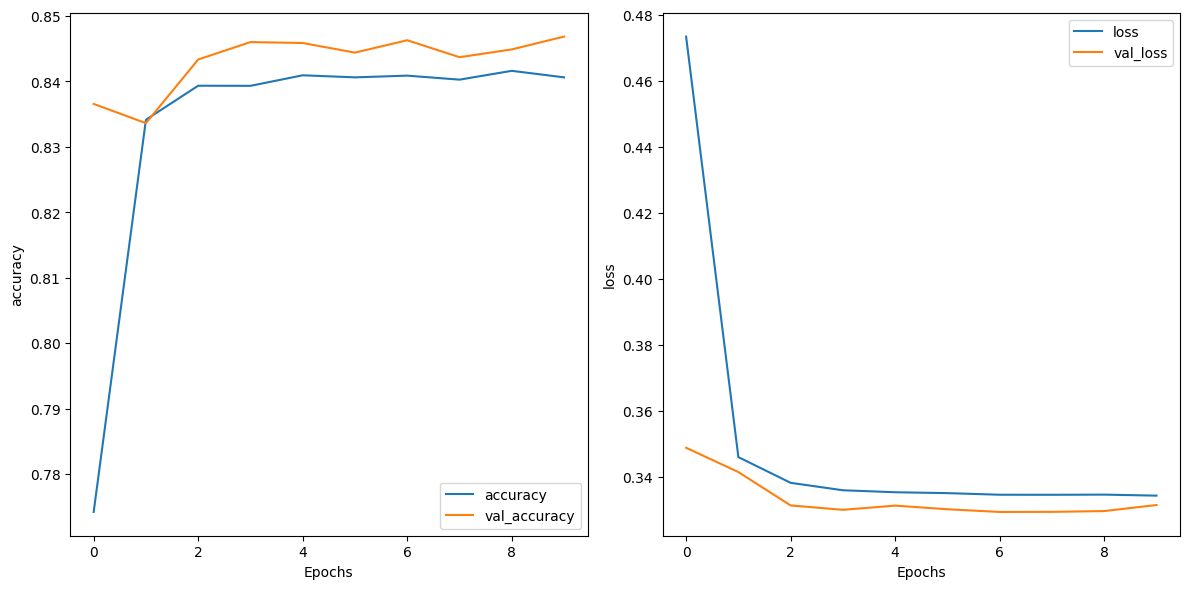

In [20]:
def plot_graphs(history, string, subplot_index):
    plt.subplot(1, 2, subplot_index)  # Create a subplot with 1 row and 2 columns
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])

plt.figure(figsize=(12, 6))

# Plot accuracy and loss as subplots
plot_graphs(history, "accuracy", 1)
plot_graphs(history, "loss", 2)

plt.tight_layout()
plt.show()


In [21]:
# Make predictions on test data
preds = model.predict(X_test)
def roundArray(number):
    ret = 0
    if number > 0.5:
        ret = 1
    return ret 

preds = preds.flatten()
result = list(map(roundArray, preds))

error = 0

for i in range(len(result)):
    res = result[i]
    true = y_test[i]
    if res != true:
        error += 1
        
nn_accuracy = round((len(result)-error)/len(result),2)
print(f' Test Accuracy = {nn_accuracy}')


447/447 [==============================] - 2s 2ms/step
 Test Accuracy = 0.85


## Step 7: Model Comparision

In [22]:
# Comparison between accuracy metrics for various models

data = {'Model': ['Logistic Regression', 
                  'Decision Tree Classifier', 
                  'Random Forest Classifier', 
                  'KNN Classifier', 
                  'Naive Bayes', 
                  'Neural Network'],
        'Test Accuracy': [lr_accuracy, 
                          dt_accuracy, 
                          rf_accuracy, 
                          knn_accuracy, 
                          nb_accuracy,
                          nn_accuracy]}
acc_df = pd.DataFrame(data)
acc_df = acc_df.sort_values(by='Test Accuracy')
print(acc_df.to_string(index=False))


                   Model  Test Accuracy
             Naive Bayes           0.60
     Logistic Regression           0.62
          KNN Classifier           0.63
Decision Tree Classifier           0.78
Random Forest Classifier           0.82
          Neural Network           0.85


* We observe that Naive Bayes classifier has the least accuracy followed by logistic regression among all the models. This is expected because Naive Bayes is a simple model and assumes feature independence. Also, it cannot capture complex relationships and patterns in the data. 
* Logistic regression is a linear model and struggles to capture complex non-linear relationships in the data, resulting in lower accuracy.
* On the other hand, Decision trees can capture complex relationships in the data, including non-linear patterns and interactions between features.
* Random Forests combine multiple decision trees to improve generalization and reduce overfitting. This ensemble approach often results in better performance, especially when there is noise or variability in the data.
* Neural networks are highly flexible models capable of learning intricate patterns in the data. They can automatically extract hierarchical features from text data. Also, they can benefit from larger datasets, as they have a higher capacity to learn complex patterns.
